In [53]:
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from river import linear_model, preprocessing, compose, metrics

In [67]:
# --- Step 1: Generate synthetic data with multiple IDs ---
def generate_data_with_ids(n_days=30, ids=('A', 'B', 'C')):
    data = []
    base_time = datetime(2025, 3, 1)
    for item_id in ids:
        for day in range(n_days):
            for hour in range(24):
                ts = base_time + timedelta(days=day, hours=hour)

                # Simulate different patterns
                if item_id == 'A':
                    clicks = max(0, int(20 + 30 * random.random() - abs(hour - 20)*4 + random.gauss(0, 2)))
                elif item_id == 'B':
                    clicks = max(0, int(10 + 10 * random.random() - abs(hour - 14)*2 + random.gauss(0, 1)))
                else:
                    clicks = max(0, int(5 + 5 * random.random() + random.gauss(0, 1)))

                data.append((item_id, ts, clicks))
    return data

data = generate_data_with_ids()

In [71]:
# --- Step 2: Feature extractor with ID ---
def extract_features(item_id: str, ts: datetime):
    return {
        'item_id': item_id,
        'hour': ts.hour,
        'day_of_week': ts.weekday(),
        'is_weekend': int(ts.weekday() >= 5)
    }

In [103]:
# --- Step 3: Setup model (handles categorical variables too) ---
model = compose.Pipeline(
    preprocessing.OneHotEncoder(),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

mae = metrics.MAE()
y_true, y_pred = [], []

In [125]:
# --- Step 4: Train & Evaluate ---
for item_id, ts, y in data:
    x = extract_features(item_id, ts)
    y_hat = model.predict_one(x) or 0
    model.learn_one(x, y)
    mae.update(y, y_hat)
    y_true.append(y)
    y_pred.append(y_hat)

print(f'MAE: {mae.get():.2f}')

MAE: 30.49


In [147]:
# --- Step 5: Plot example for a given item_id only ---
def plot_daily(target_id):
    id_true, id_pred, id_timestamps = [], [], []
    
    for (item_id, ts, y), yp in zip(data, y_pred):
        if item_id == target_id:
            id_true.append(y)
            id_pred.append(yp)
            id_timestamps.append(ts)
    print(id_pred)
    
    plt.figure(figsize=(14, 5))
    plt.plot(id_timestamps, id_true, label='True Clicks ({})'.format(target_id), alpha=0.6)
    plt.plot(id_timestamps, id_pred, label='Predicted Clicks ({})'.format(target_id), alpha=0.6)
    plt.title("True vs Predicted Clicks for ID '{}' Over Time".format(target_id))
    plt.xlabel("Timestamp")
    plt.ylabel("Clicks")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[1.6334122089872132, -25.921818420474168, 113.84715705075072, -377.1691938338612, 921.4316664150774, -1731.2821092103197, 2551.2416496354385, -2996.969569243365, 2826.3122357416128, -2148.2634810648683, 1316.8401242575774, -634.2503700656905, 252.5388136950701, -65.01921784543084, 24.478683815775618, 16.684852097009372, 15.057304656057706, 11.132598106743021, 19.108765565427518, 1.5992870512605375, 20.73756020455074, -4.2922681261647355, 2.4510910676822277, -10.543005543111432, -21.859568200115895, 4.3382898496243545, -54.541747202727365, 192.8158925642435, -514.8864985944309, 1031.845784083712, -1616.380413796546, 2004.5393114190929, -1989.346248332492, 1587.7478906191507, -1015.0673861581017, 517.3799818558165, -197.41276417873775, 78.64606090336088, 1.838533813846622, 12.771021944669814, 14.141123203445815, 14.548772013789732, 21.339540639150286, 13.744002979802787, 12.437908104849786, 14.769263042147454, 7.771770756062056, -0.7747712930443384, 1.4997901535389833, -2.583572847515860

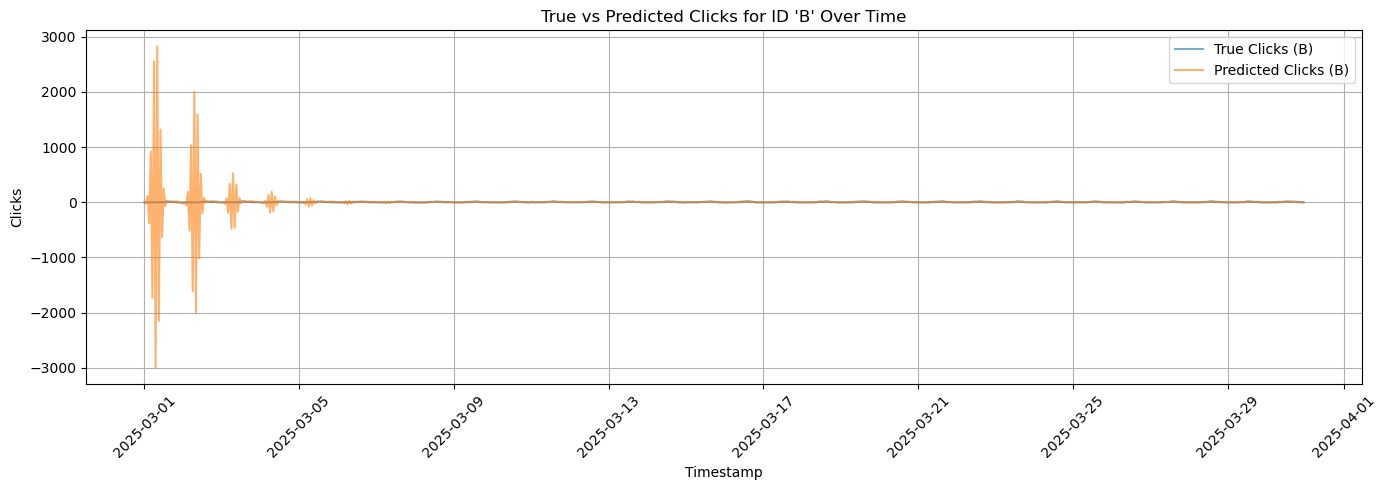

In [153]:
plot_daily('A')

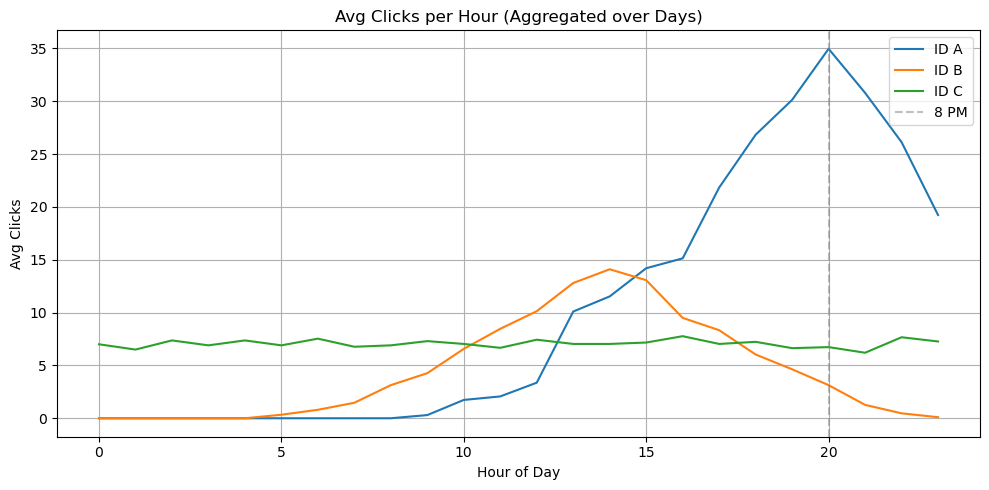

In [131]:
import pandas as pd
from collections import defaultdict

# --- Step 6: Aggregate for plotting ---
hourly_patterns = defaultdict(lambda: defaultdict(list))  # {id: {hour: [clicks]}}

for item_id, ts, y in data:
    hourly_patterns[item_id][ts.hour].append(y)

# Convert to DataFrame for plotting
df = pd.DataFrame({
    item_id: [sum(vals)/len(vals) for hour, vals in sorted(hourly_patterns[item_id].items())]
    for item_id in hourly_patterns
}, index=range(24))

# --- Step 7: Plot hourly pattern for each ID ---
plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot(df.index, df[col], label=f'ID {col}')

plt.axvline(20, color='gray', linestyle='--', alpha=0.5, label='8 PM')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Clicks')
plt.title('Avg Clicks per Hour (Aggregated over Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()